In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [ ]:
from google.colab import drive
dataset_path='/content/drive'
drive.mount('/content/drive')

# Now you can access your files in Google Drive.
# For example, to list the files in a folder:
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.file-revisions-by-id', 'Shareddrives', '.shortcut-targets-by-id', 'MyDrive', '.Trash-0']


In [ ]:
files = os.listdir(dataset_path+'/MyDrive/dataset')
print(files)


['Late Blight', 'Early Blight', 'Healthy']


# Initializing the parameters

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# Loading the dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path+'/MyDrive/dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names #0, 1, 2

['Early Blight', 'Healthy', 'Late Blight']

In [ ]:
 len(dataset) # Each element is a 32 batch

68

# Visualizing the dataset

(32, 256, 256, 3)
[0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 2 2 2 2 0 0 0 0 0 2 0 2 2 0 2 1 0]


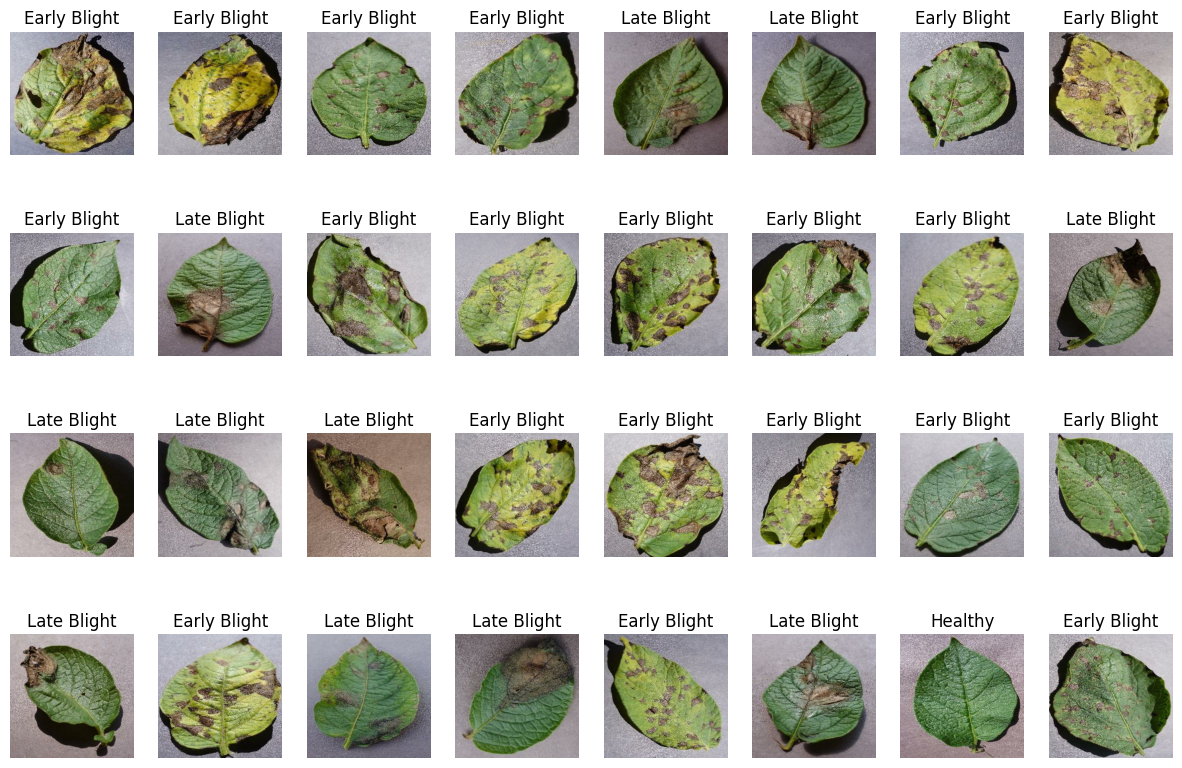

In [ ]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy()) # 0, 1, 2 for each batch of 32
    #print(image_batch[0])
    for i in range(32):
        ax = plt.subplot(4, 8, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Splitting the dataset

In [ ]:
def get_dataset_partitions_tf(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000, random_seed = 12):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = random_seed)

    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)

    train_dataset = dataset.take(train_size)

    val_dataset = dataset.skip(train_size).take(val_size)

    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, random_seed = 10)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing layers

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Model Building

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 428s 5s/step - accuracy: 0.5038 - loss: 0.9227 - val_accuracy: 0.7135 - val_loss: 0.7295
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.7194 - loss: 0.6713 - val_accuracy: 0.8229 - val_loss: 0.5814
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.8016 - loss: 0.5069 - val_accuracy: 0.8802 - val_loss: 0.3232
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.8678 - loss: 0.3193 - val_accuracy: 0.7708 - val_loss: 0.6381
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.8667 - loss: 0.3311 - val_accuracy: 0.8750 - val_loss: 0.2527
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.9177 - loss: 0.2061 - val_accuracy: 0.9062 - val_loss: 0.2406
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.8818 - loss: 0.2964 - val_accuracy: 0.9219 - val_loss: 0.1737
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.9140 - loss: 0.2152 - val_accuracy: 0.8906 - v

In [ ]:
model_2 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

model_2.build(input_shape=input_shape)

model_2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']

In [ ]:
history_2= model_2.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

In [ ]:
model_3 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

model_3.build(input_shape=input_shape)

model_3.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']

In [ ]:
history = model_3.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 481ms/step - accuracy: 0.4927 - loss: 0.9490 - val_accuracy: 0.7552 - val_loss: 0.8598
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - accuracy: 0.6915 - loss: 0.7515 - val_accuracy: 0.7812 - val_loss: 0.5421
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 477ms/step - accuracy: 0.8058 - loss: 0.4908 - val_accuracy: 0.7969 - val_loss: 0.4813
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 482ms/step - accuracy: 0.8202 - loss: 0.4589 - val_accuracy: 0.8281 - val_loss: 0.3822
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 483ms/step - accuracy: 0.8608 - loss: 0.3289 - val_accuracy: 0.8958 - val_loss: 0.3010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.9170 - loss: 0.2178 - val_accuracy: 0.9062 - val_loss: 0.2313
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.9143 - loss: 0.2053 - val_accuracy: 0.9375 - val_loss: 0.1915
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step - accuracy: 0.9086 - loss: 0.2399 - val_accu

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,243 (2.10 MB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 367,496 (1.40 MB)

In [ ]:
scores = model.evaluate(test_ds)
scores_2 = model_2.evaluate(test_ds)
scores_3 = model_3.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9725 - loss: 0.0961


In [ ]:
scores

[0.08292912691831589, 0.97265625]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy'][0:10]

[0.5352112650871277,
 0.7188966870307922,
 0.7910798192024231,
 0.8374413251876831,
 0.8796948194503784,
 0.9178403615951538,
 0.9242957830429077,
 0.920187771320343,
 0.9471830725669861,
 0.934272289276123]

In [ ]:
accur = history.history['accuracy']
val_accur = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation accuracy')

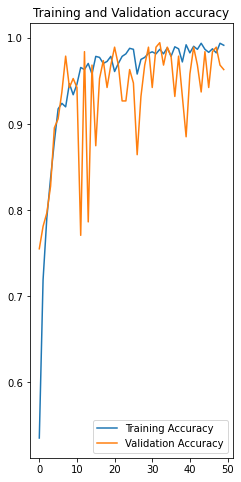

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accur, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_accur, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation accuracy')

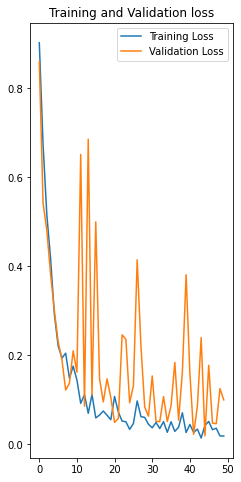

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step

Label:  Early Blight
Predicted Label:  Early Blight


2024-08-03 16:12:05.993347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


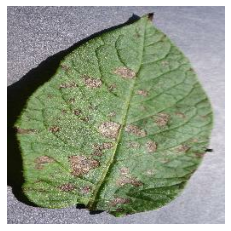

In [ ]:
import numpy as np
for images_batch, label_batch in test_ds.take(1):

    image = images_batch[0].numpy().astype('uint8')
    label = class_names[label_batch[0].numpy()]

    batch_prediction = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]

    print('\nLabel: ', label)
    print('Predicted Label: ', predicted_label, 'With an accuracy of :')

    plt.axis("off")
    plt.imshow(image)

In [ ]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0) #Create a batch

    predictions = model.predict(img_arr)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-03 16:32:30.557387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


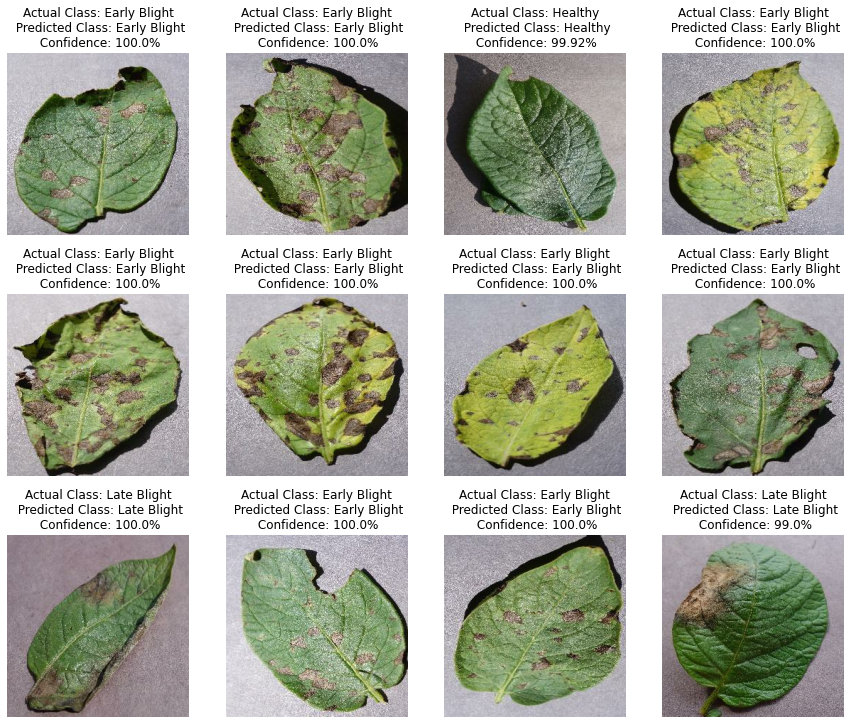

In [ ]:
plt.figure(figsize=(15, 17))

for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual Class: {actual_class}\n Predicted Class: {predicted_class}\n Confidence: {confidence}%")
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
model.save(f"../saved_models/{model_version}.keras")